In [53]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import shapely
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
sampling_resolution = 10

### Load in GeoFabrics Bathymetry estimates

In [104]:
cache_path = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\Waikanae\caches\Wellington_2013\measured_river")
depths = geopandas.read_file(cache_path / "river_bathymetry.geojson")
estimated_sections = geopandas.read_file(cache_path / "final_cross_sections.geojson")
main_channel = geopandas.read_file(cache_path / "aligned_channel_100000000.geojson")

### Specify GeoFabric parameter
Both the column names used in calculations, and also select parameter file values

In [105]:
rupp_bed_elevation_name = 'bed_elevation_Rupp_and_Smart'
neal_bed_elevation_name = 'bed_elevation_Neal_et_al'

### Plot full bank flow area and flat water area
For Rupp and Smart

<AxesSubplot:>

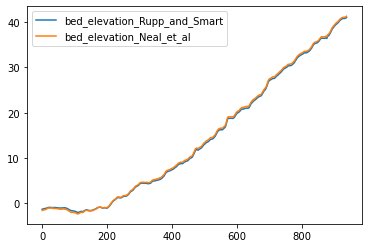

In [117]:
depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot()

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [107]:
measured_sections = geopandas.read_file(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZVD2016.geojson")

In [108]:
measured_sections.head(2)

,Number,Source,Section,Offset,Northing,Easting,Level,Code,Date,Upstream,lvd_conversion,z_2016,geometry
0,10001.0,C,10.0,0.00,6035173.66,2679120.52,2.52,CP,20141022.0,0.0,0.356669,2.163331,POINT Z (1769102.282 5473458.894 2.163)
1,10002.0,F,10.0,0.09,6035173.75,2679120.55,2.59,SH,20141022.0,0.0,0.356669,2.233331,POINT Z (1769102.312 5473458.984 2.233)


### Simplify the measured points to min point/line strings

In [113]:
section_centres = {'Section': [], 'geometry': []}
section_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections['Section'].unique():
    cross_section = measured_sections[measured_sections['Section'] == section]
    section_centre = cross_section[cross_section['Level']==cross_section['Level'].min()].iloc[0]
    section_centres['Section'].append(section)
    section_centres['geometry'].append(section_centre['geometry'])
    
    section_lines['Section'].append(section)
    section_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y] for measure_point in cross_section.geometry.values] ))
    section_lines['min_elevation'].append(cross_section['Level'].min())
section_centres = geopandas.GeoDataFrame(section_centres, crs=main_channel.crs)
section_lines = geopandas.GeoDataFrame(section_lines, crs=main_channel.crs)

## Identify the nearest depths/estimated sections

In [110]:
nearest_cross_sections = numpy.zeros_like(depths[rupp_bed_elevation_name], dtype=bool)
nearest_sections_ids = numpy.zeros_like(depths[rupp_bed_elevation_name])
for index, row in section_lines.iterrows():
    nearest_cross_sections[depths.distance(row.geometry).argmin()] = True
    nearest_sections_ids[depths.distance(row.geometry).argmin()] = row['Section']

nearest_depths = depths[nearest_cross_sections]
nearest_depths.insert(loc=0, column='Section', value=nearest_sections_ids[nearest_cross_sections])
nearest_sections = estimated_sections[nearest_cross_sections]
nearest_sections.insert(loc=0, column='Section', value=nearest_sections_ids[nearest_cross_sections])

## Update the index to be metres upstream

In [134]:
index_metres_upstream = nearest_depths.index * 10
#nearest_depths.insert(loc=0, column='Distance_Upstream', value=index_metres_upstream)
nearest_depths.set_index(['Distance_Upstream'])
section_lines.insert(loc=0, column='Distance_Upstream', value=index_metres_upstream)
section_lines.set_index(['Distance_Upstream'])

ValueError: Length of values (58) does not match length of index (59)

<AxesSubplot:>

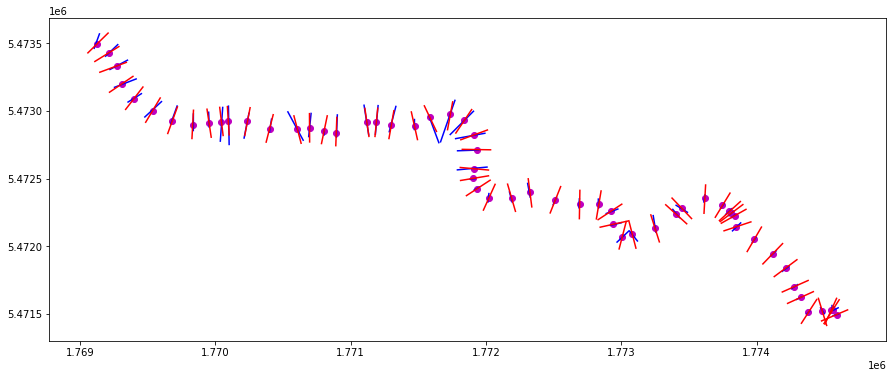

In [111]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 15))

section_lines.plot(ax=ax, color='b')
nearest_depths.plot(ax=ax, color='m')
nearest_sections.plot(ax=ax, color='r')

## Plot lowest best elevation 
Specify distance upstream with time

In [122]:
nearest_depths.columns

Index(['Section', 'bed_elevation_Neal_et_al', 'bed_elevation_Rupp_and_Smart',
       'widths', 'widths_mean_0.25km', 'flat_widths_mean_0.25km',
       'depth_Neal_et_al', 'depth_Rupp_and_Smart', 'flood_depth_Neal_et_al',
       'flood_depth_Rupp_and_Smart', 'geometry'],
      dtype='object')

In [125]:
neal_bed_elevation_name

'bed_elevation_Neal_et_al'

In [124]:
rupp_bed_elevation_name

'bed_elevation_Rupp_and_Smart'

<AxesSubplot:>

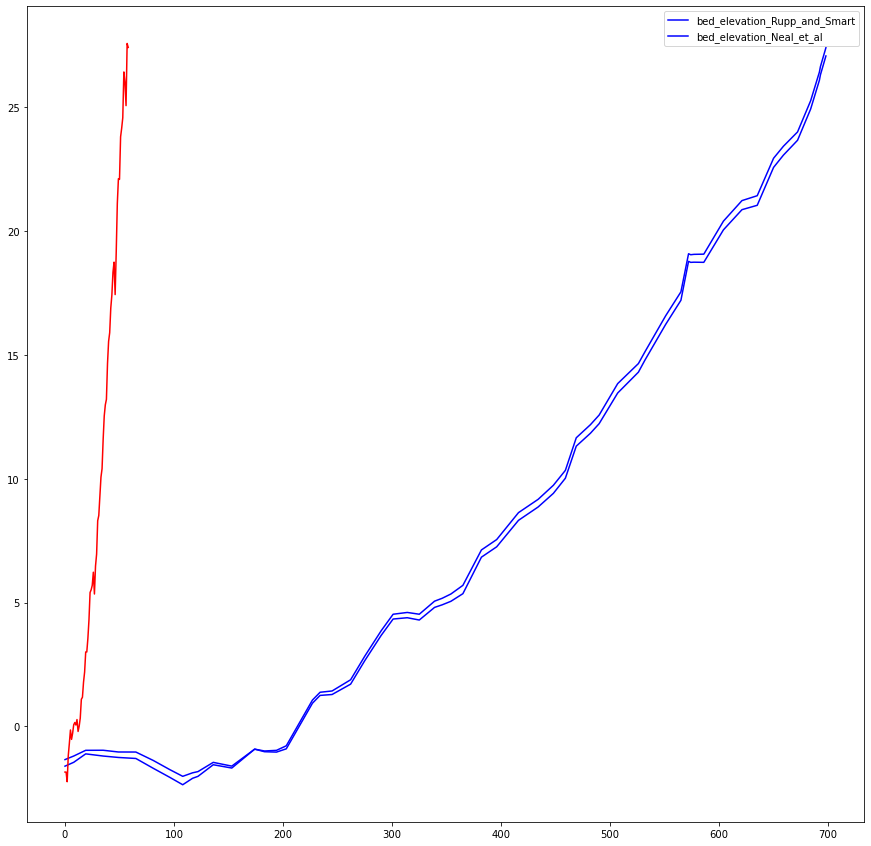

In [126]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 15))

nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax, color='b')
section_lines["min_elevation"].plot(ax=ax, color='r')

In [130]:
nearest_depths.index * 10

Int64Index([   0,   80,  190,  350,  490,  650,  810,  960, 1080, 1170, 1220,
            1360, 1530, 1740, 1830, 1940, 2030, 2270, 2340, 2450, 2620, 2750,
            2900, 3010, 3140, 3250, 3390, 3460, 3540, 3650, 3820, 3960, 4160,
            4340, 4480, 4590, 4690, 4820, 4900, 5070, 5260, 5320, 5510, 5650,
            5720, 5740, 5770, 5860, 6040, 6210, 6350, 6500, 6590, 6720, 6840,
            6920, 6930, 6980],
           dtype='int64')

In [128]:
section_lines

,Section,geometry,min_elevation
0,10.0,"LINESTRING (1769102.282 5473458.894, 1769102.3...",-1.84
1,20.0,"LINESTRING (1769184.341 5473401.670, 1769184.9...",-1.84
2,30.0,"LINESTRING (1769215.848 5473304.856, 1769216.7...",-2.23
3,40.0,"LINESTRING (1769249.033 5473173.601, 1769254.9...",-1.18
4,50.0,"LINESTRING (1769349.601 5473063.784, 1769349.7...",-0.68
5,60.0,"LINESTRING (1769474.349 5472952.647, 1769476.6...",-0.14
6,70.0,"LINESTRING (1769667.560 5472900.428, 1769667.9...",-0.52
7,80.0,"LINESTRING (1769836.572 5472850.631, 1769836.5...",-0.27
8,90.0,"LINESTRING (1769954.956 5472875.357, 1769954.7...",0.07
9,95.0,"LINESTRING (1770035.793 5472772.261, 1770035.9...",0.16


In [40]:
measured_area = []
for index, row in nearest_widths.iterrows():
    section = cross_sections[cross_sections['Section'] == row['Section']]
    section = section[section['depth'] > 0]
    measured_area.append((section['Offset'].rolling(window=2).apply(numpy.diff)
      * (section['depth']).rolling(window=2).apply(numpy.mean)).iloc[1:].sum())
nearest_areas.insert(loc=0, column='Measured areas crude', value=measured_area)

#### Calculated propely
Calculate area from where each section goes below the water surface (even if between two measurement sites)

In [22]:
def zero_crossing(x_pos: float, x_neg: float, y_pos: float, y_neg: float):
    x_zc = x_pos * -y_neg / (y_pos - y_neg) + x_neg * y_pos / (y_pos - y_neg)
    return x_zc

In [24]:
def measured_area(depth_name):
    measured_area = []
    
    for index, row in nearest_widths.iterrows():
        section = cross_sections[cross_sections['Section'] == row['Section']]
        section = section.reset_index(drop=True)
        water_elevation = row[water_elevation_name]
        area = 0
        for i in range(len(section) - 1):
            if section[depth_name][i] >= 0 and section[depth_name][i + 1] >= 0:
                # calculate Raimann square area
                area += (section['Offset'][i + 1] - section['Offset'][i]) * (section[depth_name][i] + section[depth_name][i + 1]) / 2
            elif section[depth_name][i] > 0:
                # Calculate from the left - right is above
                offset_crossing = zero_crossing(x_pos=section['Offset'][i + 1], x_neg=section['Offset'][i],
                                                y_pos=section[depth_name][i + 1], y_neg=section[depth_name][i]) 
                area += (offset_crossing - section['Offset'][i]) * section[depth_name][i] / 2
            elif section[depth_name][i + 1] > 0:
                # Calculate from the right - left is above
                offset_crossing = zero_crossing(x_pos=section['Offset'][i], x_neg=section['Offset'][i + 1],
                                                y_pos=section[depth_name][i], y_neg=section[depth_name][i + 1]) 
                area += (section['Offset'][i + 1] - offset_crossing) * section[depth_name][i + 1] / 2
        measured_area.append(area)
    return measured_area

In [27]:
measured_normal_area = measured_area('normal_depth')
measured_flood_area = measured_area('flood_depth')
nearest_areas.insert(loc=0, column='Measured normal areas', value=measured_normal_area)
nearest_areas.insert(loc=0, column='Measured flood areas', value=measured_flood_area)

<AxesSubplot:>

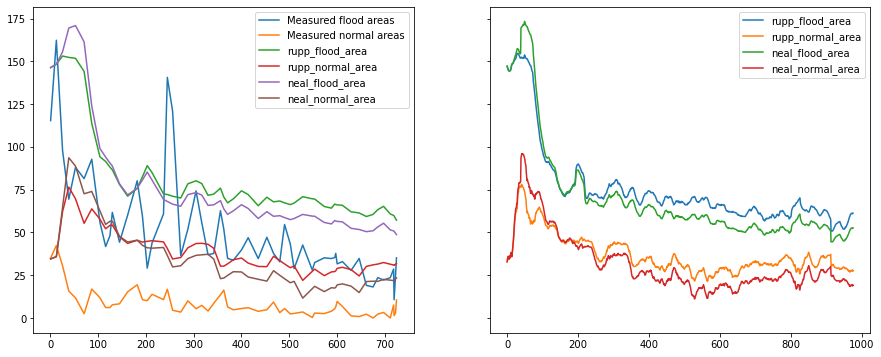

In [28]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

<AxesSubplot:>

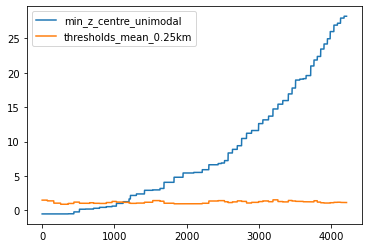

In [29]:
cross_sections[[water_elevation_name, threshold_name]].plot()

<AxesSubplot:>

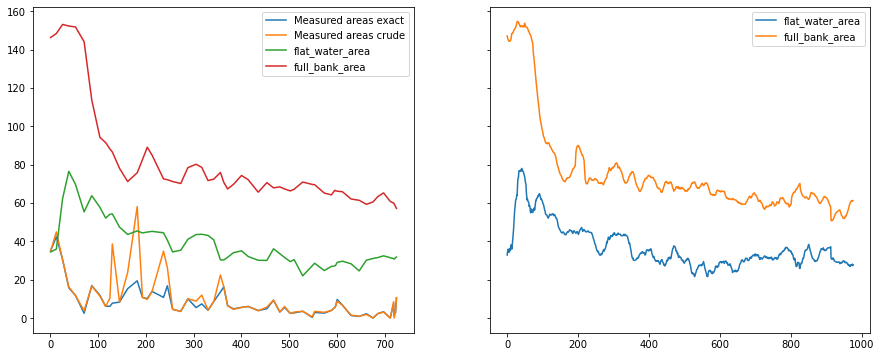

In [33]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

<AxesSubplot:>

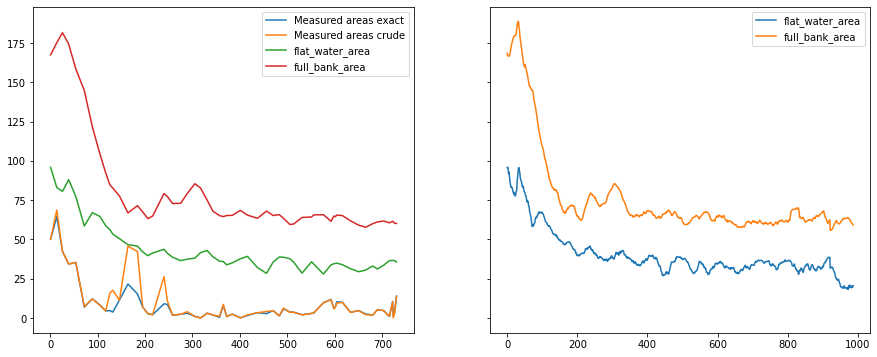

In [18]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

## Plot bed elevations and depths of the two approaches

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, figsize=(15, 6))

nearest_widths.set_index('Section', drop=True)[water_elevation_name].plot(ax=axs[0], label='Water surface elevation')
nearest_depths.set_index('Section', drop=True)['bed_elevation_Neal_et_al'].plot(ax=axs[0], label='Bed elevation calculated Neal et al')
nearest_depths.set_index('Section', drop=True)['bed_elevation_Rupp_and_Smart'].plot(ax=axs[0], label='Bed elevation calculated Rupp & Smart')
cross_sections.groupby('Section')['z_2016'].min().plot(ax=axs[0], label='Measured cross-section')
axs[0].set(title="Bed elevations estimated and measured", xlabel="Transect number where there are measured cross sections", ylabel="River bed elevation in m")
axs[0].legend()

nearest_depths.set_index('Section', drop=True)[neal_depth_name].plot(ax=axs[1], label='Calculated Neal et al depth')
nearest_depths.set_index('Section', drop=True)[rupp_depth_name].plot(ax=axs[1], label='Calculated Rupp & Smart depth')
cross_sections.groupby('Section')['depth'].max().plot(ax=axs[1], label='Measured cross-section')
axs[1].set(title="Bed depths estimated and measured", xlabel="Transect number where there are measured cross sections", ylabel="River depths in m")
axs[1].legend()

## Plot cross sections

In [ ]:
cross_sections[[water_elevation_name, 'z_2016']].plot(figsize=(15, 6))
matplotlib.pyplot.yticks(ticks=[-2.5, 0, 2.5, 10, 20, 30, 40]);
matplotlib.pyplot.grid(axis="y")

In [ ]:
f, axs = matplotlib.pyplot.subplots(2, 4, figsize=(30, 12), sharey=True)
for key, group in cross_sections.groupby('Section'):
    (-group['depth']).reset_index(drop=True).plot(ax=axs[int(key/10/28), int((key/10 - 28)/7)], label=f"{key}")
for axi in axs:
    for axij in axi:
        axij.legend()

In [ ]:
f, axs = matplotlib.pyplot.subplots(2, 4, figsize=(30, 12), sharey=True)

for key, group in cross_sections.groupby('Section'):
    group = group.copy(deep=True)
    group.loc[group['depth'] < 0, 'depth'] = numpy.nan
    (-group['depth']).reset_index(drop=True).plot(ax=axs[int(key/10/28), int((key/10 - 28)/7)], label=f"{key}")
    #print(f"key={key}, f{group['depth'].values}")
for axi in axs:
    for axij in axi:
        axij.legend()

In [ ]:
cross_sections.groupby('Section')['depth'].plot();

In [ ]:
cross_sections.groupby('Section')['z_2016'].plot();

### Plots exploring the change to width to produce an expected bed elevation

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['mannings_n'] * nearest_key_parameters['flow'] / (numpy.sqrt(nearest_key_parameters['slope']) * nearest_key_parameters['widths_Savgol'] * fudge_factor)) ** (3/5) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean'] - depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the Uniform Flow Throery approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()